In [1]:
# ------------------------------------------------------------------------------ #
# This notebook is adapted from "bayes_analysis.nb" in the same directory.
# It has been modified to analyze a model which includes information about 
# cortical layers.
# This is work in progress, and might contain many notes and questions written to help me understand and explore the methods used here.
# ------------------------------------------------------------------------------ #

%load_ext autoreload
%autoreload 2

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("../dat/")


2025-02-03 19:36:49,470 | INFO     | notebook | <module> | project directory: /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis


In [2]:

# load our results from timescale fitting
df = pd.read_hdf(f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df")

# add metrics from image selectivity and connectivity
df = utl.load_metrics(
    df.reset_index(),
    data_dir,
    csvs=[
        # we need to combine data from different files, because we use spontaneous and natural movie stimuli
        "brain_observatory_1.1_analysis_metrics.csv",
        "functional_connectivity_analysis_metrics.csv"
    ],
    cols=["on_screen_rf"],
)
df = utl.add_structure_and_hierarchy_scores(df)
df = utl.load_experiments(df, data_dir)

# pymc does not like bools:
log.info(f'invalid metric rows: {df["on_screen_rf"].isna().sum()}')
df["on_screen_rf"] = df["on_screen_rf"].astype("int")

len_before = len(df)
df = df.query("tau_R > 0.0")
df = df.query("tau_double > 0.0 & tau_double < 10.0")

# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

# some further preprocessing is done in the model class
# see ana/bayesian_models.py

# add layer data
# Note: indices of dataframe are not unit ids
unit_to_layer_df = pd.read_csv(f"{data_dir}/layers.csv")
df = pd.merge(df, unit_to_layer_df, left_index=True, right_index=True)
print(len(df))
df.head()

2025-02-03 19:36:53,477 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2025-02-03 19:36:53,665 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'on_screen_rf'] from /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/functional_connectivity_analysis_metrics.csv
2025-02-03 19:36:53,666 | INFO     | its_utility | load_metrics | Column on_screen_rf found in multiple dataframes.
2025-02-03 19:36:53,669 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/brain_observatory_1.1_analysis_metrics.csv
2025-02-03 19:36:56,654 | DEBUG    | its_utility | load_metrics | Matched 11581 rows from meta_df in /home/carlos/Git/CarlosErnestoMA/mouse_visual_timescales/experiment_analysis/dat/

16786


,unit_id_x,stimulus,session,block,ecephys_structure_acronym,invalid_spiketimes_check,recording_length,firing_rate,filepath,num_spikes,...,tau_double,tau_R_details,tau_single_details,tau_double_details,on_screen_rf,structure_name,hierarchy_score,session_type,unit_id_y,layer
0,950911932,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1078.491211,8.025100,/project.nst/neuroscience-raw/Allen/visual_cod...,8655,...,0.748946,"{'firing_rate': 8.012090922999178, 'firing_rat...","{'tau': 5.404084198337884e-05, 'mre': 6.575654...","{'tau': 0.7489462162647652, 'mre': 0.993346188...",0,AM,0.441,brain_observatory_1.1,950907205,NoLayer
1,950911986,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1079.203369,3.647135,/project.nst/neuroscience-raw/Allen/visual_cod...,3936,...,1.874703,"{'firing_rate': 3.6471291367256455, 'firing_ra...","{'tau': 2.3026338728859774, 'mre': 0.997830929...","{'tau': 1.874703126979266, 'mre': 0.9973364645...",0,AM,0.441,brain_observatory_1.1,950907209,NoLayer
2,950912164,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1077.872803,8.500075,/project.nst/neuroscience-raw/Allen/visual_cod...,9162,...,1.026284,"{'firing_rate': 8.475008697669026, 'firing_rat...","{'tau': 1.0262833654998276, 'mre': 0.995139899...","{'tau': 1.0262836602024297, 'mre': 0.995139901...",1,AM,0.441,brain_observatory_1.1,950907524,NoLayer
3,950912190,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1075.171875,4.399297,/project.nst/neuroscience-raw/Allen/visual_cod...,4730,...,1.363502,"{'firing_rate': 4.395563512916502, 'firing_rat...","{'tau': 1.5642971952849982, 'mre': 0.996808779...","{'tau': 1.363502294341311, 'mre': 0.9963396881...",1,AM,0.441,brain_observatory_1.1,950907216,NoLayer
4,950912214,natural_movie_three,715093703,merged_3.0_and_6.0,VISam,SUCCESS,1073.492432,5.326540,/project.nst/neuroscience-raw/Allen/visual_cod...,5718,...,0.377801,"{'firing_rate': 5.317211538013684, 'firing_rat...","{'tau': 0.6056864214354767, 'mre': 0.991778883...","{'tau': 0.37780093267583975, 'mre': 0.98685270...",1,AM,0.441,brain_observatory_1.1,950907220,NoLayer


### Dataframe with layers has around half as many data points as the dataframe used for the analysis without layers.

In [3]:
df_length = len(df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ))

print(f"data points in original dataframe: {str(df_length)}")

valid_layer_df = df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM'] & "
    + "layer in ['2/3', '4', '5', '6']"
    )
print(f"data points in dataframe with layers: {str(len(valid_layer_df))}")

data points in original dataframe: 4554
data points in dataframe with layers: 2282


     mu_layer_23_offset ~ Normal(0, 1)
  sigma_layer_23_offset ~ HalfCauchy(0, 1)
      mu_layer_4_offset ~ Normal(0, 1)
   sigma_layer_4_offset ~ HalfCauchy(0, 1)
      mu_layer_5_offset ~ Normal(0, 1)
   sigma_layer_5_offset ~ HalfCauchy(0, 1)
      mu_layer_6_offset ~ Normal(0, 1)
   sigma_layer_6_offset ~ HalfCauchy(0, 1)
           mu_intercept ~ Normal(0, 1)
        sigma_intercept ~ HalfCauchy(0, 1)
               mu_slope ~ Normal(0, 1)
            sigma_slope ~ HalfCauchy(0, 1)
      session_intercept ~ Normal(mu_intercept, sigma_intercept)
          session_slope ~ Normal(mu_slope, sigma_slope)
session_layer_23_offset ~ Normal(mu_layer_23_offset, sigma_layer_23_offset)
 session_layer_4_offset ~ Normal(mu_layer_4_offset, sigma_layer_4_offset)
 session_layer_5_offset ~ Normal(mu_layer_5_offset, sigma_layer_5_offset)
 session_layer_6_offset ~ Normal(mu_layer_6_offset, sigma_layer_6_offset)
                b_os_rf ~ Normal(0, 1)
               b_log_fr ~ Normal(0, 1)
            

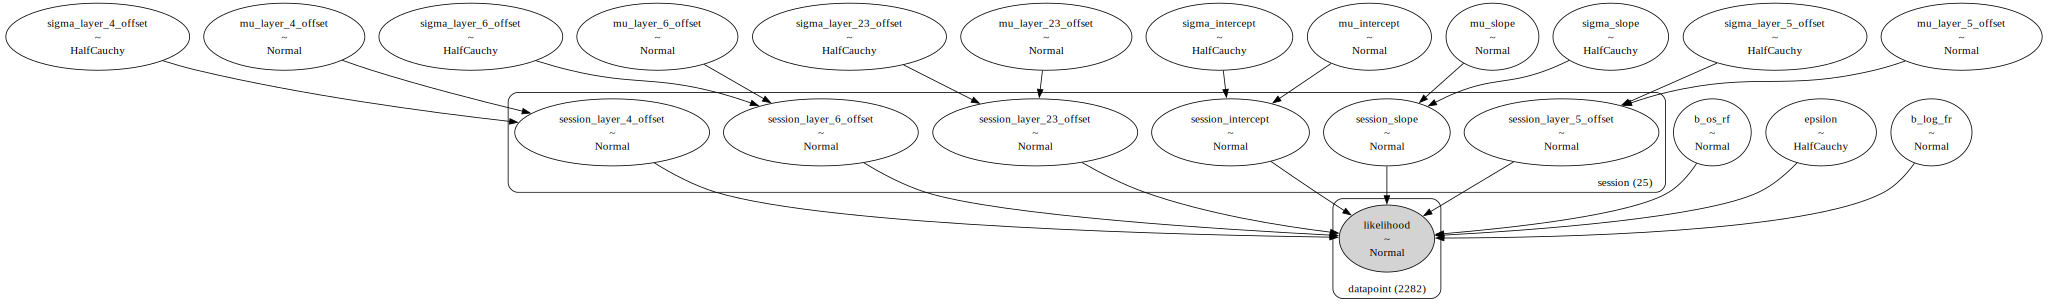

In [6]:
#Linear Median Mode with layers, tau R:
LMM_Layers_R_tot = bm.LinearMedianModelWithLayers(
    df=valid_layer_df,
    measure="R_tot",
    noncentered=False,
)
print(LMM_Layers_R_tot.str_repr())
pm.model_to_graphviz(LMM_Layers_R_tot)

In [7]:
with LMM_Layers_R_tot:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

ValueError: Sampling failed: All initialization points failed

Caused by:
    Logp function returned error: Logp function returned error code 3

In [10]:
## try with normal model
LMM_tau_R = bm.LinearMedianModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
with LMM_tau_R:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )

In [11]:
## try with SG model
SG_tau_R = bm.StructureGroupModel(
    df=df.query(
        "stimulus == 'natural_movie_one_more_repeats'  & "
        + "structure_name in ['V1', 'LM', 'RL', 'AL', 'PM', 'AM']"
    ),
    measure="tau_R",
    noncentered=True,
)
with SG_tau_R:
    idata = pm.sample(
        nuts_sampler="nutpie",
        draws=3000,
        tune=2000,
        random_seed=42,
        target_accept=0.95,
    )